# Learning Shapelets

## Reference

This refers to the following paper by Grabocka _et al._:
> Learning Time-Series Shapelets. 
> Josif Grabocka, Nicolas Schilling, Martin Wistuba, Lars Schmidt-Thieme
> http://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

## Content

In this paper, authors suggest that one should rather learn time series that are likely to lead to good classification instead of finding them in the data, as was done by previous works.
The optimization strategy is a standard gradient descent over shapelets elements and logistic regression coefficients.
Experiments are conducted on the UCR datasets.



In [1]:
%matplotlib inline

import numpy
import os
import matplotlib.pyplot as plt

def load_dataset(ds_name, path="data/ucr"):
    directory = "%s/%s" % (path, ds_name)
    fname_train, fname_test = None, None
    for fname in os.listdir(directory):
        if fname.endswith("_TRAIN.txt"):
            fname_train = os.path.join(directory, fname)
        elif fname.endswith("_TEST.txt"):
            fname_test = os.path.join(directory, fname)
    data_train = numpy.loadtxt(fname_train)
    n, sz = data_train.shape
    x_train, y_train = data_train[:, 1:].reshape((n, sz - 1, 1)), data_train[:, 0]
    data_test = numpy.loadtxt(fname_test)
    n, sz = data_test.shape
    x_test, y_test = data_test[:, 1:].reshape((n, sz - 1, 1)), data_test[:, 0]
    return x_train, y_train, x_test, y_test

numpy.random.seed(0)
x_train, y_train, x_test, y_test = load_dataset("GunPoint", "../../TSC_dataset/data_out/")
print(y_train)

# 0/1 setup
y_train[y_train <= 1.5] = 0
y_train[y_train > 1.5] = 1
y_test[y_test <= 1.5] = 0
y_test[y_test > 1.5] = 1

print(x_train.shape, x_test.shape)

[ 2.  2.  1.  1.  2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  2.  1.  2.  2.
  1.  2.  1.  1.  1.  2.  1.  2.  1.  1.  2.  1.  1.  2.  2.  1.  2.  1.
  2.  2.  2.  2.  2.  1.  1.  1.  2.  2.  1.  2.  1.  2.]
(50, 150, 1) (150, 150, 1)


Let us start by defining some basic functions that compute the gradient of the loss wrt shapelet coefficients, and all it needs to be computed:

In [2]:
def shapelet_transform_with_offset(ts_i, shapelets):
    L = ts_i.shape[0]
    dists = []
    for shp in shapelets:
        sz = shp.shape[0]
        dists.append(numpy.min([numpy.linalg.norm(ts_i[t:t+sz] - shp) ** 2 for t in range(L-sz+1)]) / sz)
    return numpy.array([1] + dists)

def predict(ts_i, shapelets, weights):
    return 1. / (1 + numpy.exp(- numpy.dot(weights, shapelet_transform_with_offset(ts_i, shapelets))))

def loss(time_series, classes, shapelets, weights, lambda_w):
    total_loss = 0.
    for ts_i, yi in zip(time_series, classes):
        s_yi_hat = predict(ts_i, shapelets, weights)
        total_loss += - yi * numpy.log(s_yi_hat) - (1. - yi) * numpy.log(1 - s_yi_hat)
    total_loss += lambda_w * numpy.linalg.norm(weights) ** 2
    return total_loss / time_series.shape[0]

def grad_Skl(ts_i, y_i, shapelets, weights):
    dL_dYi = - (y_i - predict(ts_i, shapelets, weights))
    n_shapelets = len(shapelets)
    L = ts_i.shape[0]
    dYi_dSkl = []
    for k in range(n_shapelets):
        sz = shapelets[k].shape[0]
        dYi_dMik = weights[k + 1]
        j = numpy.argmin([numpy.linalg.norm(ts_i[t:t+sz] - shapelets[k]) ** 2 for t in range(L-sz+1)])
        dMik_dSkl = shapelets[k] - ts_i[j:j+sz] # Limit when alpha -> -inf
        dYi_dSkl.append(dYi_dMik * dMik_dSkl / sz)
    return [dL_dYi * dYi_dSkl[k] for k in range(n_shapelets)]

def grad_Wk(ts_i, y_i, shapelets, weights, lambda_w, n_samples):
    n_shapelets = len(shapelets)
    gr = - 0.5 * (y_i - predict(ts_i, shapelets, weights)) * shapelet_transform_with_offset(ts_i, shapelets)
    gr += lambda_w * weights / n_samples
    return gr

In [3]:
n_shapelets = 10
lambda_w = 0.01
shapelets = [numpy.random.randn(10, 1) for k in range(n_shapelets)]  # 3 random shapelets of size 10
weights = numpy.random.randn(n_shapelets + 1)
print(loss(x_train, y_train, shapelets, weights, lambda_w))

3.21689666243


Let us know have a look at what the stochastic gradient descent looks like:

In [4]:
def update_shapelets_and_weights(ts_i, y_i, shapelets, weights, lambda_w, n_samples, eta):
    delta_Skl = grad_Skl(ts_i, y_i, shapelets, weights)
    delta_Wk = grad_Wk(ts_i, y_i, shapelets, weights, lambda_w, n_samples)
    
    weights -= eta * delta_Wk
    for k in range(len(shapelets)):
        shapelets[k] -= eta * delta_Skl[k]
    return shapelets, weights

eta = 0.01
for i in range(10001):  # 10k iterations
    idx = numpy.random.randint(x_train.shape[0])
    ts_i = x_train[idx]
    y_i = y_train[idx]
    shapelets, weights = update_shapelets_and_weights(ts_i, y_i, shapelets, weights, lambda_w, x_train.shape[0], eta)
    if i % 1000 == 0:
        print(i, loss(x_train, y_train, shapelets, weights, lambda_w=0.01))

0 3.1800762401
1000 0.696701439932
2000 0.660313246894
3000 0.634371287791
4000 0.61472695118
5000 0.598396268421
6000 0.577425054152
7000 0.56358965226
8000 0.554658712193
9000 0.54568691458
10000 0.537483338189


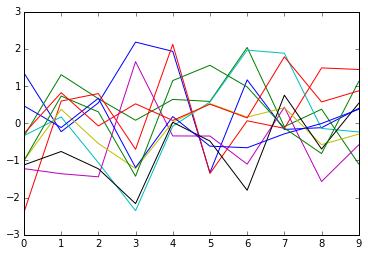

In [5]:
for shp in shapelets:
    plt.plot(numpy.arange(shp.shape[0]), shp)

Of course, this code is not optimized (some quantities are computed several time at each iteration), but it gives an idea of how LS works.

In [6]:
n_correct = 0
for idx_test in range(x_test.shape[0]):
    yi_hat = predict(x_test[idx_test], shapelets, weights)
    if (yi_hat > .5 and y_test[idx_test] == 1) or (yi_hat <= .5 and y_test[idx_test] == 0):
        n_correct += 1
print(n_correct, x_test.shape[0])

123 150


Note that in this implementation, we do not perform k-means initialization as in the original paper.

## Adversarial time series

Now, let us generate adversarial samples that are very close to correctly classified time series but can still fool the system.
To do so, we perform gradient descent on time series elements.

In [7]:
def grad_Rij(ts_i, target_label, shapelets, weights):
    dL_dYi = - (target_label - predict(ts_i, shapelets, weights))
    n_shapelets = len(shapelets)
    L = ts_i.shape[0]
    dYi_dTij = numpy.zeros(ts_i.shape)
    for k in range(n_shapelets):
        sz = shapelets[k].shape[0]
        j_star = numpy.argmin([numpy.linalg.norm(ts_i[t:t+sz] - shapelets[k]) ** 2 for t in range(L-sz+1)])
        dYi_dTij[j_star:j_star+sz] += weights[k+1] * (ts_i[j_star:j_star+sz] - shapelets[k]) / sz
    return dL_dYi * dYi_dTij

idx_ts = 47
ts_i = x_train[idx_ts].copy()
y_true = y_train[idx_ts]
y_target = 1 - y_true

print(y_true, predict(ts_i, shapelets, weights))

eta = 0.001
lambda_res = .5
residual = numpy.zeros(ts_i.shape)
for niter in range(50001):
    residual -= eta * grad_Rij(ts_i, y_target, shapelets, weights)
    residual -= eta * lambda_res * residual
    ts_i = x_train[idx_ts] + residual
    if niter % 1000 == 0:
        print(niter, predict(ts_i, shapelets, weights), 
              numpy.linalg.norm(ts_i - x_train[idx_ts]) / numpy.linalg.norm(x_train[idx_ts]))
        if numpy.abs(y_target - predict(ts_i, shapelets, weights)) < 0.45:
            print("Stopped after %d iterations" % niter)
            break

1.0 0.785020018241
0 0.784546282923 8.59371283904e-05
1000 0.506018007117 0.0443624598499
2000 0.40123083795 0.0590308018887
Stopped after 2000 iterations


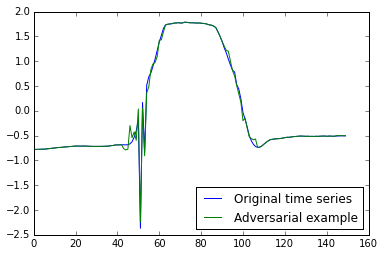

In [8]:
L = ts_i.shape[0]
plt.plot(numpy.arange(L), x_train[47], label="Original time series")
plt.plot(numpy.arange(L), ts_i, label="Adversarial example")
plt.legend(loc="lower right")